In [12]:
import bayes3d as b
import bayes3d.genjax
import joblib
from tqdm import tqdm
import os
import jax.numpy as jnp
import jax
import numpy as np
import genjax

In [17]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7036/static/


In [2]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=500.0, fy=500.0,
    cx=50.0, cy=50.0,
    near=0.01, far=20.0
)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)

b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/1000000000.0)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [3]:
importance_jit = jax.jit(b.model.importance)
key = jax.random.PRNGKey(10)

In [4]:
gt_traces = []
NUM_TRACES = 100
for scene_id in tqdm(range(NUM_TRACES)):
    filename = f"data/trace_{scene_id}.joblib"
    gt_traces.append(importance_jit(key, *joblib.load(filename))[1][1])

hb_traces = []

V_VARIANT = 0
O_VARIANT = 0
HIERARCHICAL_BAYES = True

for scene_id in tqdm(range(NUM_TRACES)):
    if HIERARCHICAL_BAYES:
        filename = f"data/inferred_hb_{scene_id}.joblib"
    else:
        filename = f"data/inferred_{V_VARIANT}_{O_VARIANT}_{scene_id}.joblib"
    hb_traces.append(importance_jit(key, *joblib.load(filename))[1][1])

  0%|                                                                                                                                                                                                 | 0/100 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'data/trace_0.joblib'

In [ ]:
# Classification accuracy
prediction_sets = [hb_traces]
wrong_prediction = []
for pred_set in prediction_sets:
    correct = 0
    for scene_id in range(NUM_TRACES):
        gt_ids = np.array(b.genjax.get_indices(gt_traces[scene_id]))
        pred_ids = np.array(b.genjax.get_indices(pred_set[scene_id]))
        # print(pred_set[scene_id]["variance"])
        # print(pred_set[scene_id]["outlier_prob"])
        if set(pred_ids) == set(gt_ids):
            correct +=1
        else:
            wrong_prediction.append(scene_id)
            print(gt_ids, pred_ids)
            continue
    print(correct)    

In [ ]:
wrong_prediction

In [ ]:
b.genjax.viz_trace_meshcat(prediction_sets[0][scene_id])

In [7]:

importance_jit = jax.jit(b.model.importance)

contact_enumerators = [b.make_enumerator([f"contact_params_{i}", "variance", "outlier_prob"]) for i in range(5)]
add_object_jit = jax.jit(b.add_object)

def c2f_contact_update(trace_, key,  number, contact_param_deltas, VARIANCE_GRID, OUTLIER_GRID):
    contact_param_grid = contact_param_deltas + trace_[f"contact_params_{number}"]
    scores = contact_enumerators[number][3](trace_, key, contact_param_grid, VARIANCE_GRID, OUTLIER_GRID)
    i,j,k = jnp.unravel_index(scores.argmax(), scores.shape)
    return contact_enumerators[number][0](
        trace_, key,
        contact_param_grid[i], VARIANCE_GRID[j], OUTLIER_GRID[k]
    )
c2f_contact_update_jit = jax.jit(c2f_contact_update, static_argnames=("number",))

In [15]:
OUTLIER_VOLUME = 1000.0
VARIANCE_GRID = jnp.array([0.0001, 0.001, 0.01])
OUTLIER_GRID = jnp.array([0.00001, 0.0001, 0.001])

grid_params = [
    (0.3, jnp.pi, (11,11,11)), (0.2, jnp.pi, (11,11,11)), (0.1, jnp.pi, (11,11,11)),
    (0.05, jnp.pi/3, (11,11,11)), (0.02, jnp.pi, (5,5,51)), (0.01, jnp.pi/5, (11,11,11)), (0.01, 0.0, (21,21,1)),(0.05, 0.0, (21,21,1))
]
contact_param_gridding_schedule = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]
key = jax.random.PRNGKey(500)


In [9]:
scene_id = 4

In [10]:
V_VARIANT = 0
O_VARIANT = 0
HIERARCHICAL_BAYES = True

if HIERARCHICAL_BAYES:
    V_GRID = VARIANCE_GRID
    O_GRID = OUTLIER_GRID
else:
    V_GRID, O_GRID = jnp.array([VARIANCE_GRID[V_VARIANT]]), jnp.array([OUTLIER_GRID[O_VARIANT]])

print(V_GRID, O_GRID)

gt_trace = importance_jit(key, *joblib.load(f"data/trace_{scene_id}.joblib"))[1][1]
print(b.genjax.get_indices(gt_trace))
b.genjax.viz_trace_meshcat(gt_trace)
choices = gt_trace.get_choices()
key, (_,trace) = importance_jit(key, choices, (jnp.arange(1), jnp.arange(22), *gt_trace.get_args()[2:-1], 100.0))
print(trace.get_score())

[1.e-04 1.e-03 1.e-02] [1.e-05 1.e-04 1.e-03]


FileNotFoundError: [Errno 2] No such file or directory: 'data/trace_4.joblib'

In [60]:
table_pose = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 2.0, 1.20]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)

weight, gt_trace = importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "parent_1": 0,
    "parent_2": 0,
    "parent_3": 0,
    "id_0": jnp.int32(21),
    "camera_pose": jnp.eye(4),
    "root_pose_0": table_pose,
    "face_parent_1": 2,
    "face_parent_2": 2,
    "face_parent_3": 2,
    "face_child_1": 3,
    "face_child_2": 3,
    "face_child_3": 3,
    "variance": 0.0001,
    "outlier_prob": 0.0001,
}), (
    jnp.arange(4),
    jnp.arange(22),
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
    jnp.array([jnp.array([-0.2, -0.2, -2*jnp.pi]), jnp.array([0.2, 0.2, 2*jnp.pi])]),
    b.RENDERER.model_box_dims, OUTLIER_VOLUME, 1.0)
)
print(gt_trace.get_score())

20379.018


In [62]:
_,trace = importance_jit(key, trace.get_choices(), (jnp.arange(1), jnp.arange(22), *gt_trace.get_args()[2:]))

In [63]:
b.viz_trace_meshcat(trace)

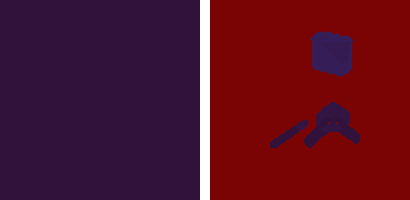

In [67]:
b.viz_trace_rendered_observed(trace)

In [68]:
b.viz_trace_meshcat(trace)

In [69]:
all_all_paths = []
for _ in range(3):
    all_paths = []
    for obj_id in tqdm(range(len(b.RENDERER.meshes)-1)):
        path = []
        trace_ = add_object_jit(trace, key, obj_id, 0, 2,3)
        number = b.get_contact_params(trace_).shape[0] - 1
        path.append(trace_)
        for c2f_iter in range(len(contact_param_gridding_schedule)):
            trace_ = c2f_contact_update_jit(trace_, key, number,
                contact_param_gridding_schedule[c2f_iter], V_GRID, O_GRID)
            path.append(trace_)
        # for c2f_iter in range(len(contact_param_gridding_schedule)):
        #     trace_ = c2f_contact_update_jit(trace_, key, number,
        #         contact_param_gridding_schedule[c2f_iter], VARIANCE_GRID, OUTLIER_GRID)
        all_paths.append(
            path
        )
    all_all_paths.append(all_paths)
    
    scores = jnp.array([t[-1].get_score() for t in all_paths])
    print(scores)
    normalized_scores = b.utils.normalize_log_scores(scores)
    trace = all_paths[jnp.argmax(scores)][-1]
    b.viz_trace_meshcat(trace)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:25<00:00,  1.22s/it]


[ 8770.71    9125.907   9316.053  12317.326   9892.555  10098.149
 10303.576  10441.819  13257.952  10642.229   6126.5645  9849.467
  8173.9663 12708.57    8521.694   8001.7485 11233.768   9569.525
 11571.687  10099.448  11542.227 ]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:26<00:00,  1.25s/it]


[ 8834.159   9457.573  13536.434  13922.481  13320.626  17203.004
 16818.121  17546.678  14207.539  17747.086   6866.7344 10654.357
 13583.376  14491.718  14964.268   8630.085  18338.623  16674.38
 18676.541  17204.303  16751.135 ]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:27<00:00,  1.32s/it]

[14252.408 14875.821 16766.928 18052.918 16327.13  18660.936 18661.297
 18661.22  18633.955 18969.807 12284.984 16072.606 16796.842 18418.238
 16210.065 14048.336 19724.238 20187.729 18547.414 17793.326 18661.416]


In [25]:
trace.get_score()

Array(nan, dtype=float32)

In [21]:


all_all_paths = []
for _ in range(3):
    all_paths = []
    for obj_id in tqdm(range(len(b.RENDERER.meshes)-1)):
        path = []
        trace_ = add_object_jit(trace, key, obj_id, 0, 2,3)
        number = b.genjax.get_contact_params(trace_).shape[0] - 1
        path.append(trace_)
        for c2f_iter in range(len(contact_param_gridding_schedule)):
            trace_ = c2f_contact_update_jit(trace_, key, number,
                contact_param_gridding_schedule[c2f_iter], V_GRID, O_GRID)
            path.append(trace_)
        # for c2f_iter in range(len(contact_param_gridding_schedule)):
        #     trace_ = c2f_contact_update_jit(trace_, key, number,
        #         contact_param_gridding_schedule[c2f_iter], VARIANCE_GRID, OUTLIER_GRID)
        all_paths.append(
            path
        )
    all_all_paths.append(all_paths)
    
    scores = jnp.array([t[-1].get_score() for t in all_paths])
    print(scores)
    normalized_scores = b.utils.normalize_log_scores(scores)
    trace = all_paths[jnp.argmax(scores)][-1]
    b.genjax.viz_trace_meshcat(trace)

print(b.genjax.get_indices(gt_trace))
print(b.genjax.get_indices(trace))
b.genjax.viz_trace_meshcat(trace)

  0%|                                                                                                                                                                                                                         | 0/21 [00:00<?, ?it/s]2023-07-18 19:29:36.522162: W external/xla/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:561] libdevice is required by this HLO module but was not found at /opt/conda/envs/bayes3d/lib/python3.9/site-packages/nvidia/cuda_nvcc/nvvm/libdevice/libdevice.10.bc
2023-07-18 19:29:36.525514: W external/xla/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:561] libdevice is required by this HLO module but was not found at /opt/conda/envs/bayes3d/lib/python3.9/site-packages/nvidia/cuda_nvcc/nvvm/libdevice/libdevice.10.bc
2023-07-18 19:29:36.527243: W external/xla/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:561] libdevice is required by this HLO module but was not found at /opt/conda/envs/bayes3d/lib/python3.9/site-packages/nvidia/cuda_nvcc/

XlaRuntimeError: INTERNAL: libdevice not found at /opt/conda/envs/bayes3d/lib/python3.9/site-packages/nvidia/cuda_nvcc/nvvm/libdevice/libdevice.10.bc

In [183]:
b.genjax.print_trace(trace)



    SCORE: 446075.1250000
    VARIANCE: 0.0000100
    OUTLIER_PROB 0.0010000
    


In [184]:
b.genjax.viz_trace_meshcat(gt_trace)

In [186]:
trace_alternate = all_all_paths[2][18][-1]
trace_alternate2 = all_all_paths[2][19][-1]
b.genjax.print_trace(trace_alternate)
b.genjax.print_trace(trace_alternate2)
b.genjax.viz_trace_meshcat(trace_alternate)
b.genjax.viz_trace_meshcat(trace_alternate2)


    SCORE: 446075.1250000
    VARIANCE: 0.0000100
    OUTLIER_PROB 0.0010000
    

    SCORE: 445532.4375000
    VARIANCE: 0.0000100
    OUTLIER_PROB 0.0010000
    
